In [1]:
# Fixing paths
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras, py_func
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import r2_score

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

In [3]:
from tensorflow.keras.callbacks import TensorBoard

In [4]:
np.random.seed(10)
tf.set_random_seed(10)

In [5]:
def r2_2(y_true, y_pred):
    res = py_func(r2_score, [y_true, y_pred], tf.float64)
    return res

In [6]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

## Load model

In [7]:
HERE = os.path.abspath('')
print(HERE)

/home/jeba/Thesis/data_to_IVW/Airfoil_seven_Experiments/E2_acrossBC_M2/training/baseline


In [8]:
total_data = np.load(HERE+'/Total_dataset.npy')

In [9]:
total_samples = np.shape(total_data)[0]

np.random.shuffle(total_data) # Randomizing data

mv_scaler = StandardScaler()

mv_scaler.fit(total_data[:,:])

mv_scaler_filename = "mv_scaler.save"

joblib.dump(mv_scaler, mv_scaler_filename)

total_data[:,:] = mv_scaler.transform(total_data[:,:])

### Randomize the data

In [10]:
np.random.shuffle(total_data)

num_outputs = 1
num_inputs = np.shape(total_data)[1] - num_outputs

training_inputs = total_data[:,0:num_inputs]

training_outputs = total_data[:,num_inputs:].reshape(total_samples,num_outputs)

## Get Model

In [11]:
num_neurons = 60
num_layers = 6
num_epochs = 500

In [12]:
ph_input = keras.Input(shape=(num_inputs,),name='input_placeholder')

hidden_layer = keras.layers.Dense(num_neurons,activation='tanh')(ph_input)

W0512 00:56:44.731725 140273477592896 deprecation.py:506] From /home/jeba/tensorflow-venv/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
for layer in range(num_layers):
        hidden_layer = keras.layers.Dense(num_neurons,activation='tanh')(hidden_layer)

In [14]:
output = keras.layers.Dense(num_outputs,activation='linear',name='output_value')(hidden_layer)

In [15]:
model = keras.Model(inputs=[ph_input],outputs=[output])

loss = tf.keras.losses.MeanSquaredError()

my_adam = keras.optimizers.Adam(lr=0.001, decay=0.0)

In [16]:
model.compile(optimizer=my_adam,loss={'output_value': 'mean_squared_error'},metrics=[r2_2])

W0512 00:56:44.929492 140273477592896 deprecation.py:323] From <ipython-input-5-336ece99eb7d>:2: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_placeholder (InputLaye [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 60)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_4 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_5 (Dense)              (None, 60)                3660  

## calback and fit model

In [18]:
 model_path = './model.h5'

In [19]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

checkpoint = keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min',save_weights_only=False)

csv_logger = keras.callbacks.CSVLogger('training.log')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [20]:
history = model.fit({'input_placeholder': training_inputs},
                        {'output_value': training_outputs},
                        epochs=num_epochs, 
                        batch_size=1024,callbacks=[tbCallBack,checkpoint,csv_logger,earlystopping],
                        validation_split=0.1,verbose=1)

Train on 119232 samples, validate on 13248 samples
Epoch 1/500
116736/119232 [============================>.] - ETA: 0s - loss: 0.8803 - r2_2: 0.1200
Epoch 00001: val_loss improved from inf to 0.69239, saving model to ./model.h5
119232/119232 [==============================] - 1s 12us/sample - loss: 0.8719 - r2_2: 0.1281 - val_loss: 0.6924 - val_r2_2: 0.3154
Epoch 2/500
110592/119232 [==========================>...] - ETA: 0s - loss: 0.4071 - r2_2: 0.5908
Epoch 00002: val_loss improved from 0.69239 to 0.25689, saving model to ./model.h5
119232/119232 [==============================] - 1s 11us/sample - loss: 0.3957 - r2_2: 0.6024 - val_loss: 0.2569 - val_r2_2: 0.7492
Epoch 3/500
115712/119232 [============================>.] - ETA: 0s - loss: 0.2770 - r2_2: 0.7195
Epoch 00003: val_loss did not improve from 0.25689
119232/119232 [==============================] - 1s 7us/sample - loss: 0.2777 - r2_2: 0.7204 - val_loss: 0.2934 - val_r2_2: 0.7108
Epoch 4/500
113664/119232 [=================

117760/119232 [============================>.] - ETA: 0s - loss: 0.0579 - r2_2: 0.9418
Epoch 00056: val_loss improved from 0.04598 to 0.04347, saving model to ./model.h5
119232/119232 [==============================] - 1s 7us/sample - loss: 0.0579 - r2_2: 0.9420 - val_loss: 0.0435 - val_r2_2: 0.9570
Epoch 57/500
110592/119232 [==========================>...] - ETA: 0s - loss: 0.0737 - r2_2: 0.9267
Epoch 00057: val_loss did not improve from 0.04347
119232/119232 [==============================] - 1s 6us/sample - loss: 0.0717 - r2_2: 0.9288 - val_loss: 0.0844 - val_r2_2: 0.9175
Epoch 58/500
109568/119232 [==========================>...] - ETA: 0s - loss: 0.0733 - r2_2: 0.9257
Epoch 00058: val_loss did not improve from 0.04347
119232/119232 [==============================] - 1s 6us/sample - loss: 0.0729 - r2_2: 0.9264 - val_loss: 0.0735 - val_r2_2: 0.9287
Epoch 59/500
110592/119232 [==========================>...] - ETA: 0s - loss: 0.0650 - r2_2: 0.9352
Epoch 00059: val_loss did not impro

In [21]:
keras.models.load_model(model_path,custom_objects={'r2_2': r2_2})

frozen_graph = freeze_session(keras.backend.get_session(), output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, './', 'ML_SA_CG.pb', as_text=False)



W0512 00:58:12.675607 140273477592896 deprecation.py:506] From /home/jeba/tensorflow-venv/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0512 00:58:12.679064 140273477592896 deprecation.py:506] From /home/jeba/tensorflow-venv/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0512 00:58:14.241405 140273477592896 deprecation.py:323] From <ipython-input-6-0d92ab84a915>:26: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) 

'./ML_SA_CG.pb'

In [22]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph


In [23]:
graph = load_graph('ML_SA_CG.pb')

In [24]:
 for op in graph.get_operations():
        print(op.name)

prefix/input_placeholder
prefix/dense/kernel
prefix/dense/bias
prefix/dense/MatMul/ReadVariableOp
prefix/dense/MatMul
prefix/dense/BiasAdd/ReadVariableOp
prefix/dense/BiasAdd
prefix/dense/Tanh
prefix/dense_1/kernel
prefix/dense_1/bias
prefix/dense_1/MatMul/ReadVariableOp
prefix/dense_1/MatMul
prefix/dense_1/BiasAdd/ReadVariableOp
prefix/dense_1/BiasAdd
prefix/dense_1/Tanh
prefix/dense_2/kernel
prefix/dense_2/bias
prefix/dense_2/MatMul/ReadVariableOp
prefix/dense_2/MatMul
prefix/dense_2/BiasAdd/ReadVariableOp
prefix/dense_2/BiasAdd
prefix/dense_2/Tanh
prefix/dense_3/kernel
prefix/dense_3/bias
prefix/dense_3/MatMul/ReadVariableOp
prefix/dense_3/MatMul
prefix/dense_3/BiasAdd/ReadVariableOp
prefix/dense_3/BiasAdd
prefix/dense_3/Tanh
prefix/dense_4/kernel
prefix/dense_4/bias
prefix/dense_4/MatMul/ReadVariableOp
prefix/dense_4/MatMul
prefix/dense_4/BiasAdd/ReadVariableOp
prefix/dense_4/BiasAdd
prefix/dense_4/Tanh
prefix/dense_5/kernel
prefix/dense_5/bias
prefix/dense_5/MatMul/ReadVariableOp


In [25]:
input_tensor = model.inputs[0]
output_tensor = model.outputs[0]
print("Inputs: "+str(input_tensor))
print("Outputs: "+str(output_tensor))

Inputs: Tensor("input_placeholder:0", shape=(?, 6), dtype=float32)
Outputs: Tensor("output_value/BiasAdd:0", shape=(?, 1), dtype=float32)


In [26]:
import matplotlib as plt
from matplotlib import pyplot as plt 
from matplotlib.ticker import FormatStrFormatter

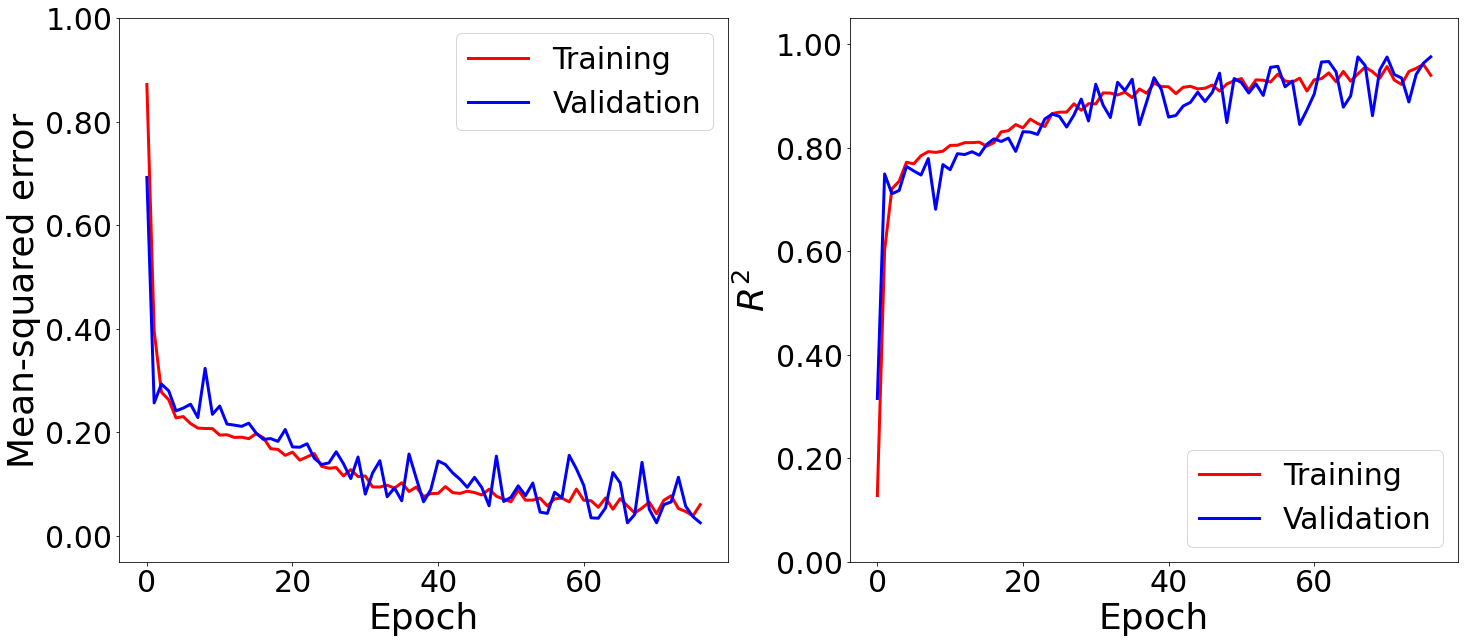

In [27]:
# Plot the loss function
# (ax1, ax2) = plt.subplots(1, 2)
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(24,10))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax1.grid()
ax1.set_ylim([-0.05, 1])
ax1.plot((history.history['loss']), 'r', label='Training',linewidth=3.0)
ax1.plot((history.history['val_loss']), 'b' ,label='Validation',linewidth=3.0)
ax1.set_xlabel(r'Epoch', fontsize=36)
ax1.set_ylabel(r'Mean-squared error', fontsize=36)
ax1.legend(fontsize=30)
# ax1.legend(fontsize=30)
ax1.tick_params(labelsize=30)

# Plot the accuracy
# fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax2.grid()
ax2.set_ylim([0, 1.05])
ax2.plot((history.history['r2_2']), 'r', label='Training',linewidth=3.0)
ax2.plot((history.history['val_r2_2']), 'b' ,label='Validation',linewidth=3.0)
ax2.set_xlabel(r'Epoch', fontsize=36)
ax2.set_ylabel(r'$R^2$', fontsize=36)
ax2.legend(fontsize=30)
ax2.tick_params(labelsize=30)

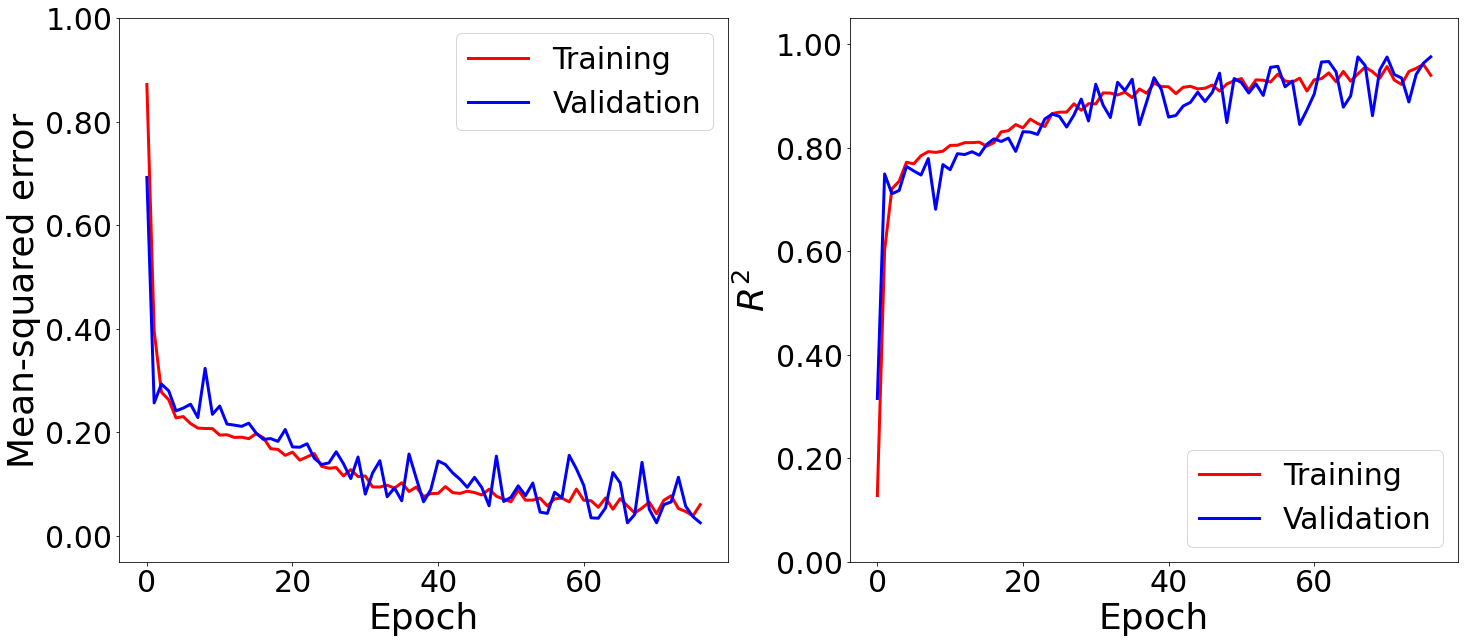

In [28]:
# Plot the loss function
# (ax1, ax2) = plt.subplots(1, 2)
fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(24,10))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax1.grid()
ax1.set_ylim([-0.05, 1])
ax1.plot((history.history['loss']), 'r', label='Training',linewidth=3.0)
ax1.plot((history.history['val_loss']), 'b' ,label='Validation',linewidth=3.0)
ax1.set_xlabel(r'Epoch', fontsize=36)
ax1.set_ylabel(r'Mean-squared error', fontsize=36)
ax1.legend(fontsize=30)
# ax1.legend(fontsize=30)
ax1.tick_params(labelsize=30)

# Plot the accuracy
# fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax2.grid()
ax2.set_ylim([0, 1.05])
ax2.plot((history.history['r2_2']), 'r', label='Training',linewidth=3.0)
ax2.plot((history.history['val_r2_2']), 'b' ,label='Validation',linewidth=3.0)
ax2.set_xlabel(r'Epoch', fontsize=36)
ax2.set_ylabel(r'$R^2$', fontsize=36)
ax2.legend(fontsize=30)
ax2.tick_params(labelsize=30)